In [ ]:
#trying our basic unet for segmentation

import os
import cv2
import glob
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

img_width=128
img_height=128
img_channels=3

# changed
base_path='/home/JGY/mri_cnn/data/segmentation_Dataset/brisc2025/segmentation_task'

train_image_path= os.path.join(base_path,'train/images')
train_mask_path= os.path.join(base_path,'train/masks')
test_image_path= os.path.join(base_path,'test/images')
test_mask_path= os.path.join(base_path,'test/masks')

def load_preprocess(image_dir, mask_dir):
  image_files=sorted(glob.glob(os.path.join(image_dir, '*.*')))
  mask_files=sorted(glob.glob(os.path.join(mask_dir, '*.*')))
  if len(image_files) != len(mask_files):
    print(f"Error: Mismatch in file counts")
    print(f"Images found: {len(image_files)}, masks found = {len(image_files)}")
    return None, None
  X= []
  Y=[]
  print(f"Loading{len(image_files)}images and masks..")

  for img_path, mask_path in zip(image_files, mask_files):
    try:
      img=cv2.imread(img_path, cv2.IMREAD_COLOR)
      img=cv2.resize(img, (img_width, img_height))
      img=img/255.0
      mask= cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
      mask=cv2.resize(mask,(img_width, img_height))
      mask=(mask>128).astype(np.float32)
      X.append(img)
      Y.append(mask)
    except Exception as e:
     print(f"Error loading image or mask: {e}")

  X=np.array(X)
  Y=np.array(Y)
  Y=np.expand_dims(Y, axis=-1)

  return X, Y

X_train, y_train= load_preprocess(train_image_path, train_mask_path)
X_test, y_test= load_preprocess(test_image_path, test_mask_path)
print(f"\nData loading complete.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")






2025-11-16 14:26:25.305298: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-16 14:26:25.312087: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763270785.320679  370035 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763270785.323282  370035 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763270785.329519  370035 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Loading3933images and masks..
Loading860images and masks..

Data loading complete.
X_train shape: (3933, 128, 128, 3)
y_train shape: (3933, 128, 128, 1)
X_test shape:  (860, 128, 128, 3)
y_test shape:  (860, 128, 128, 1)


In [2]:
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Concatenate, Conv2DTranspose, LeakyReLU
)
from tensorflow.keras.models import Model
def build_unet(input_shape=(img_width, img_height, img_channels)):
  inputs=Input(input_shape)
  def conv_block(x, filters, kernel_size=3, dropout=0.1): #helper for convolution
        x = Conv2D(filters, (kernel_size, kernel_size), padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.01)(x)
        x = Conv2D(filters, (kernel_size, kernel_size), padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.01)(x)
        if dropout > 0:
            x = Dropout(dropout)(x)
        return x
  def upsample_block(x, skip, filters, kernel_size=3): #helper function to upsample
        x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
        x = Concatenate()([x, skip])
        x = conv_block(x, filters, kernel_size, dropout=0)
        return x
  s1 = conv_block(inputs, 64) #encoder
  p1 = MaxPooling2D((2, 2))(s1)
  s2 = conv_block(p1, 128)
  p2 = MaxPooling2D((2, 2))(s2)
  s3 = conv_block(p2, 256)
  p3 = MaxPooling2D((2, 2))(s3)

  b = conv_block(p3, 512, dropout=0.3) #bottleneck

  u3 = upsample_block(b, s3, 256) # deocder
  u2 = upsample_block(u3, s2, 128)
  u1 = upsample_block(u2, s1, 64)

  outputs = Conv2D(1, (1, 1), activation='sigmoid')(u1)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

unet_model = build_unet()
unet_model.summary()

I0000 00:00:1763270804.572236  370035 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14067 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/JGY/anaconda3/envs/mri_2025_11/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ leaky_re_lu[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ leaky_re_lu_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ leaky_re_lu_2[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ leaky_re_lu_3[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ dropout_1[0][0] 

 Total params: 7,708,609 (29.41 MB)

 Trainable params: 7,702,977 (29.38 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [3]:
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def dice_coefficient(y_true, y_pred, smooth=1):#dice loss
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

unet_model.compile(
    optimizer=Adam(learning_rate=1e-4), # adjust later for tuning, go higher
    loss=dice_loss,
    metrics=[dice_coefficient]
)

callbacks = [
    EarlyStopping(
        monitor='val_dice_coefficient', # stops when this metric stops improving
        patience=10,
        mode='max', #maximizes the dice coefficient
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath='best_unet_model_real_masks.h5',
        monitor='val_dice_coefficient',
        mode='max',
        save_best_only=True
    )
]

print("\nStart Unet training\n")
history = unet_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=16, #can adjust later
    epochs=100,
    callbacks=callbacks
)


Start Unet training

Epoch 1/100


I0000 00:00:1763270818.101147  370121 service.cc:152] XLA service 0x7946340140a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763270818.101171  370121 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2025-11-16 14:26:58.183470: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1763270818.670159  370121 cuda_dnn.cc:529] Loaded cuDNN version 90101


  3/246 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - dice_coefficient: 0.0368 - loss: 0.9632 

I0000 00:00:1763270826.561427  370121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - dice_coefficient: 0.1565 - loss: 0.8435

246/246 ━━━━━━━━━━━━━━━━━━━━ 32s 86ms/step - dice_coefficient: 0.2552 - loss: 0.7448 - val_dice_coefficient: 0.0291 - val_loss: 0.9708
Epoch 2/100
245/246 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - dice_coefficient: 0.4333 - loss: 0.5667

246/246 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - dice_coefficient: 0.4716 - loss: 0.5284 - val_dice_coefficient: 0.1819 - val_loss: 0.8179
Epoch 3/100
245/246 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - dice_coefficient: 0.5755 - loss: 0.4245

246/246 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - dice_coefficient: 0.5860 - loss: 0.4139 - val_dice_coefficient: 0.5404 - val_loss: 0.4600
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - dice_coefficient: 0.6398 - loss: 0.3601 - val_dice_coefficient: 0.4316 - val_loss: 0.5695
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - dice_coefficient: 0.7002 - loss: 0.2998 - val_dice_coefficient: 0.4419 - val_loss: 0.5586
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - dice_coefficient: 0.7035 - loss: 0.2965

246/246 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - dice_coefficient: 0.7160 - loss: 0.2841 - val_dice_coefficient: 0.6658 - val_loss: 0.3348
Epoch 7/100
245/246 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - dice_coefficient: 0.7278 - loss: 0.2722

246/246 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - dice_coefficient: 0.7406 - loss: 0.2595 - val_dice_coefficient: 0.7172 - val_loss: 0.2834
Epoch 8/100
245/246 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - dice_coefficient: 0.7735 - loss: 0.2265

246/246 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - dice_coefficient: 0.7752 - loss: 0.2247 - val_dice_coefficient: 0.7280 - val_loss: 0.2726
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - dice_coefficient: 0.7811 - loss: 0.2188 - val_dice_coefficient: 0.7063 - val_loss: 0.2944
Epoch 10/100
245/246 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - dice_coefficient: 0.7413 - loss: 0.2587

246/246 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - dice_coefficient: 0.7602 - loss: 0.2398 - val_dice_coefficient: 0.7455 - val_loss: 0.2550
Epoch 11/100
245/246 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - dice_coefficient: 0.7974 - loss: 0.2026

246/246 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - dice_coefficient: 0.7981 - loss: 0.2019 - val_dice_coefficient: 0.7576 - val_loss: 0.2430
Epoch 12/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - dice_coefficient: 0.7947 - loss: 0.2053 - val_dice_coefficient: 0.7538 - val_loss: 0.2468
Epoch 13/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - dice_coefficient: 0.7429 - loss: 0.2571 - val_dice_coefficient: 0.7229 - val_loss: 0.2778
Epoch 14/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - dice_coefficient: 0.7894 - loss: 0.2105 - val_dice_coefficient: 0.7339 - val_loss: 0.2668
Epoch 15/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - dice_coefficient: 0.7671 - loss: 0.2329 - val_dice_coefficient: 0.7528 - val_loss: 0.2476
Epoch 16/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - dice_coefficient: 0.7005 - loss: 0.2995 - val_dice_coefficient: 0.6730 - val_loss: 0.3278
Epoch 17/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - dice_coefficient: 0.7435 - loss: 0.2565 - val_dice_coefficient: 0.7


Evaluating on the test set
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - dice_coefficient: 0.7664 - loss: 0.2340
Test Set Dice Score (F1): 0.7664
Generating predicted masks for visualization...
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


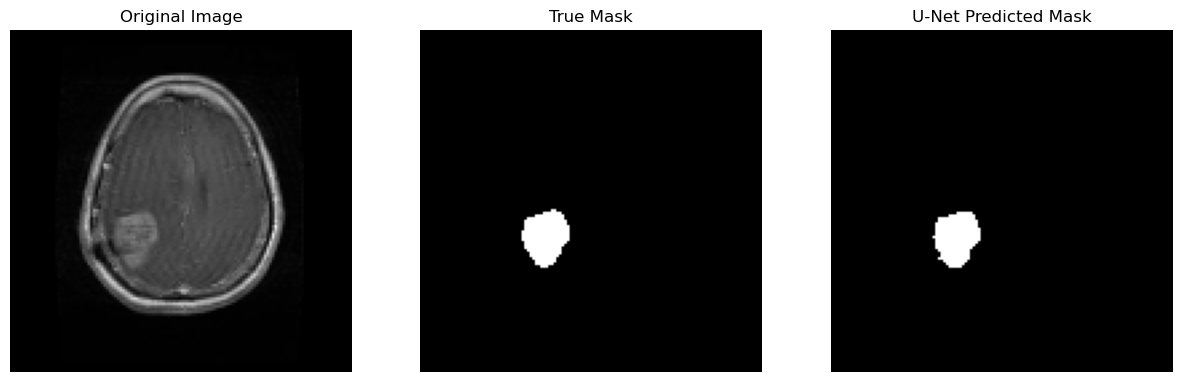

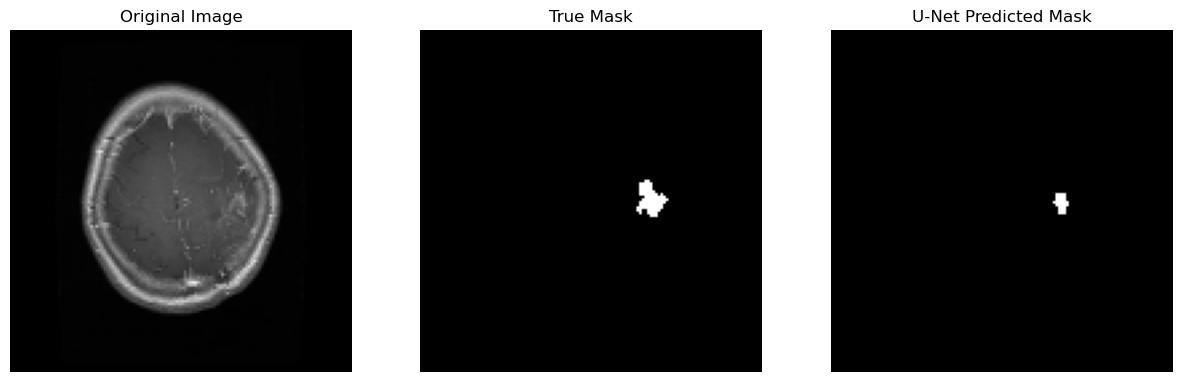

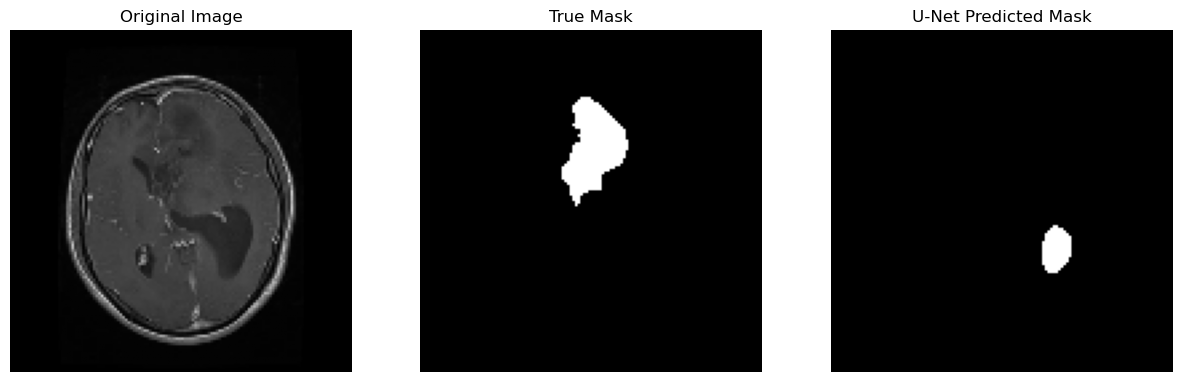

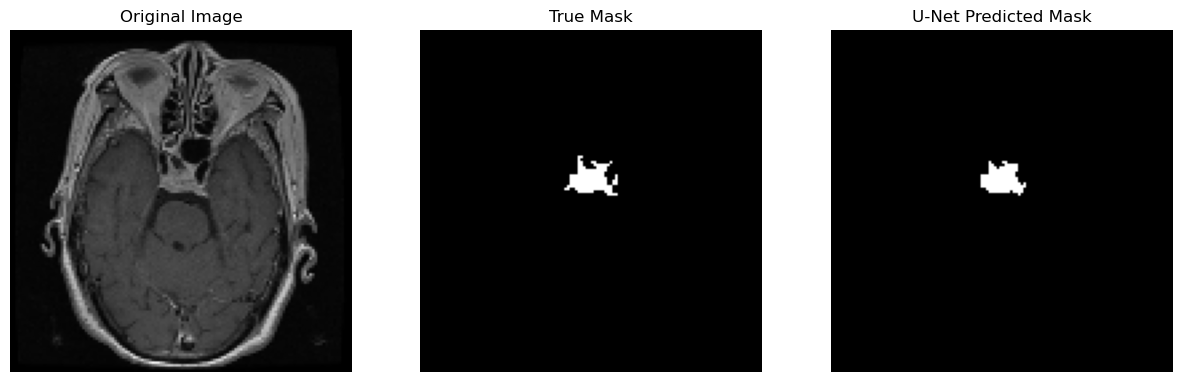

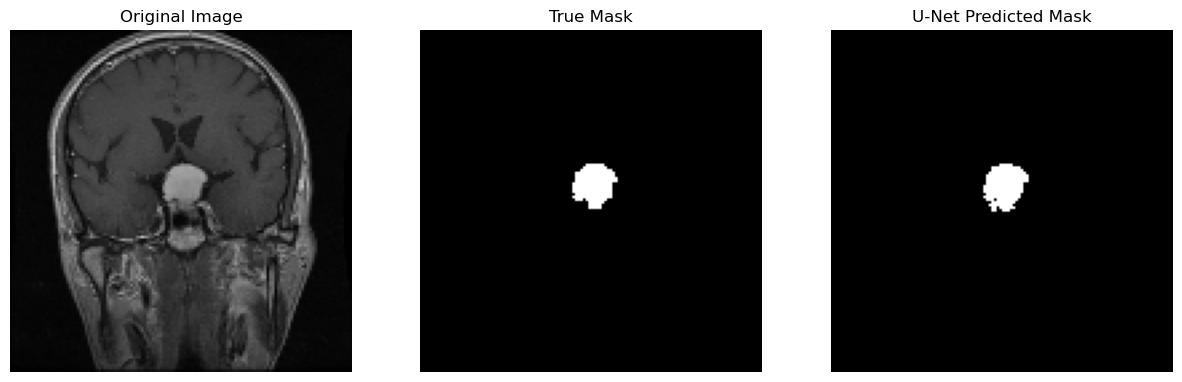

In [5]:
import matplotlib.pyplot as plt

print("\nEvaluating on the test set")
# 'loss'-> dice loss, dice_score is dice coefficient
loss, dice_score = unet_model.evaluate(X_test, y_test)
print(f"Test Set Dice Score (F1): {dice_score:.4f}")

#predict masks
print("Generating predicted masks for visualization...")
predicted_masks = unet_model.predict(X_test)

num_to_show = 5
for i in range(num_to_show):
    idx = np.random.randint(0, len(X_test))
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(X_test[idx])
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    #true mask
    ax[1].imshow(y_test[idx].squeeze(), cmap='gray')
    ax[1].set_title("True Mask")
    ax[1].axis("off")

    # predicted mask, binarize threshold
    pred_mask = (predicted_masks[idx] > 0.5).astype(np.float32)
    ax[2].imshow(pred_mask.squeeze(), cmap='gray')
    ax[2].set_title("U-Net Predicted Mask")
    ax[2].axis("off")

    plt.show()